# Example: microgenerator simulation
In this tutorial we'll create and simulate a microgenerator using `FFS`.

## Background
<img src='./_img/mcrg.png' width=600px></img>

In `FFS`, we can simulate and optimize energy harvesters that have the same architecture and basic properties as shown above.
Namely, the energy harvester must be a single-axis, cylindrical microgenerators that consist of one or more evenly-spaced coils wound around the outside of the body.
Inside the body is a moving magnet assembly, suspended by a magnetic spring, that consists of one or more evenly-spaced magnets.

We simulate these devices by composing a number of "submodels" together, each representing parts of the mechanical system, the electrical system or the interaction between these two systems. This means we'll need to specify a number of different components:

- The magnet assembly
- The coil(s)
- The flux curve model
- The mechanical friction
- The electro-mechanical damping (coupling) force
- The magnetic spring behaviour
- The target load
- The rectification voltage drop
- The impact dynamics
- The input excitation
- The device height
- The behavioural system model

This may seem a bit daunting at first-glance, but fortunately `FFS` has been designed to make defining and simulating these devices as painless as possible. Let's dive in.

## Creating a base model
Let's start by first creating a base microgenerator model, without any components or submodels attached to it.
First, we'll have to import `FFS`:

In [2]:
import numpy as np

import ffs  # FFS import

We define all models using the `UnifiedModel` class from the `unified` module:

In [3]:
model = ffs.unified.UnifiedModel()

Due to the iterative and exploratory nature of energy harvester design, `FFS` makes it easy to inspect its various components.
We can `print` most components to get an overview of their properties:

In [4]:
print(model)  # Print our base model

Unified Model: 
  height: None
  governing_equations: None
  time: None
  raw_solution: None
  post_processing_pipeline: {}
  magnetic_spring: None
  magnet_assembly: None
  mechanical_spring: None
  mechanical_damper: None
  input_excitation: None
  flux_model: None
  coil_configuration: None
  rectification_drop: None
  load_model: None
  coupling_model: None
  extra_components: {}


## Creating components

Currently, we can see that our `model` is completely empty -- no components are currently attached to it.

Let's define some components that we can attach.

### Device height
Let's start by declaring the height that we want our microgenerator to have:

In [5]:
device_height = 120 / 1000   # must be in metres!

### Magnet assembly
Let's create a magnet assembly, which lives in the `mechanical_componets` module of `FFS`:

In [6]:
magnet_assembly = ffs.mechanical_components.magnet_assembly.MagnetAssembly(
    m=1,  # Number of magnets
    l_m_mm=10,  # Magnet length
    l_mcd_mm=0,  # Spacing between magnets (not relevant to this example)
    dia_magnet_mm=10,  # Magnet diameter
    dia_spacer_mm=0  # Spacer diamer (also not relevant here)
)

To look-up the meaning of each parameter, we can use the `?` operator to lookup any component's documentation (`FFS` is fully documented): 

In [7]:
ffs.mechanical_components.magnet_assembly.MagnetAssembly?

Init signature:
ffs.mechanical_components.magnet_assembly.MagnetAssembly(
    m: int,
    l_m_mm: float,
    l_mcd_mm: float,
    dia_magnet_mm: float,
    dia_spacer_mm: float,
    mat_magnet='NdFeB',
    mat_spacer='iron',
)
Docstring:     
Represent a magnet assembly.

Parameters
----------
m : int
    Number of magnets.
l_m_mm : float
    Height of the magnets in mm.
l_mcd_mm : float
    Distance between the centers of each magnet, in mm.
dia_magnet_mm: float
    Diameter of magnets in mm.
dia_spacer_mm : float
    Diameter of spacer in mm
mat_magnet : str
    Magnet material key. Optional.
mat_spacer: str
    Spacer material key. Optional.
Init docstring: Constructor
File:           ~/Nextcloud/nextcloud/PhD/Python/unified_model/ffs/mechanical_components/magnet_assembly.py
Type:           type
Subclasses:     


We can also inspect most `FFS` objects using `print`, like we saw earlier:

In [8]:
print(magnet_assembly)

MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=0)


### Mechanical damper
Let's create our mechanical damper, which allows us to model mechanical losses due to friction:

In [9]:
mechanical_damper = ffs.mechanical_components.damper.MassProportionalDamper(
    damping_coefficient=4.272,
    magnet_assembly=magnet_assembly  # This depends on our `magnet_assembly`!
)

Note that in order to define our mechanical damper, we needed to pass in our `magnet_assembly` we created earlier! Now, you might be wondering,

"if I change my magnet assembly configuration later, will I also have to respecify my mechanical damper?" 

The answer is no! To make iteration and experimentaiton easier, **`FFS` automatically keeps track of dependencies, and updates components whenever their dependencies are changed.**
We'll demonstrate this in a later tutorial, but for now, you can trust that `FFS` will make sure components are updated as their dependencies change.

### Coil configuration
Let's define a coil configuration, which specifies all the properties of our coils:

In [10]:
coil_configuration = ffs.electrical_components.coil.CoilConfiguration(
    c=1,  # Number of coils
    n_z=15,  # Vertical windings
    n_w=17,  # Horizontal windings
    l_ccd_mm=0,  # Coil spacing
    ohm_per_mm=1079 / 1000 / 1000,  # Ohm per mm of wire
    coil_wire_radius_mm=0.143 / 2,  # Wire radius
    coil_center_mm=72-13,  # Coil center location
    inner_tube_radius_mm=5.5,  # Inner tube radius of microgenerator body
    tube_wall_thickness_mm=2  # Wall thickness of the microgenerator body
)

### Magnetic spring
Let's define our magnetic spring, that models the magnetic-levitation spring dynamics of the magnet assembly:

In [11]:
magnetic_spring = ffs \
.mechanical_components.magnetic_spring.MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_assembly=magnet_assembly
)

In this case, we use simulated FEA data to model our spring.
The FEA data file specifies the force experienced between two pole-matched 10mm x 10mm cylindrical magnets (which are the same as the magnets defined in our magnet assembly).

### Flux model
Next, let's define our flux model. Our flux model allows us to predict a the magnetic flux captured by the coil(s) given the coil properties, magnet assembly and their relative position.
In our case, we'll be using a pre-trained flux curve model. In this particular case, our pre-trained model is specific to our 10mm x 10mm cylindrical magnets and choice of copper wire:

In [15]:
flux_model = ffs.electrical_components.flux.FluxModelPretrained(
    coil_configuration=coil_configuration,
    magnet_assembly=magnet_assembly,
    curve_model_path='../data/flux_curve_model/flux_curve_model_2022_08_09.model'
)

### Coupling
Here we define out coupling model, that models the interaction between the electrical and mechanical systems:

In [16]:
coupling = ffs.coupling.CouplingModel(coupling_constant=5.096)

### Impact dynamics
Let's also define the impact dynamics that occur when the magnet assembly impacts the top of the microgenerator device.
In this case, we model it as a lossy mechanical spring  / collision:

In [17]:
mechanical_spring = ffs.mechanical_components.mechanical_spring.MechanicalSpring(
    magnet_assembly=magnet_assembly,
    damping_coefficient=3.108
)

### Target load
Let's define our target load as a 30 Ohm resistor:

In [18]:
load_model = ffs.electrical_components.load.SimpleLoad(R=30)

### Rectification drop
`FFS` allows us to model the rectification drop from a full-wave bridge rectifier. In this case, like with the device height, we only need to specify a float value:

In [19]:
v_rect_drop = 0.05  # 50 millivolts

### Input excitation
We also need to add an input excitation, which will drive the microgenerator. We'll use some footstep-like accelerometer measurements:

In [20]:
input_excitation = ffs.mechanical_components.input_excitation.accelerometer.AccelerometerInput(
    raw_accelerometer_data_path='../data/2019-05-23/A/log_01_acc.csv',
    accel_column='z_G',
    time_column='time(ms)',
    accel_unit='g',
    time_unit='ms'
)

## Defining the system behaviour model
The last thing we need to specify is the the system behavioural model, or what's known as the `governing_equations` function.
The function defines all behaviour and interaction of the various components within the microgenerator. 

If you wanted to simulate your own electromechanical energy harvester model, you'd need to define your own `governing_equations` function.

Fortunately, `FFS` ships with a `unified_ode` governing equations function (which all of this research is built upon), which is what we'll also here:

In [21]:
governing_equations = ffs.governing_equations.unified_ode

## Assembling the model
Finally, let's add all our components, input excitation and governing equations to our model:

In [22]:
model = model \
    .with_height(device_height) \
    .with_magnet_assembly(magnet_assembly) \
    .with_coil_configuration(coil_configuration) \
    .with_magnetic_spring(magnetic_spring) \
    .with_mechanical_damper(mechanical_damper) \
    .with_mechanical_spring(mechanical_spring) \
    .with_coupling_model(coupling) \
    .with_flux_model(flux_model) \
    .with_rectification_drop(v_rect_drop) \
    .with_load_model(load_model) \
    .with_input_excitation(input_excitation) \
    .with_governing_equations(governing_equations)

In addition to being able `print` our various models and components, the `UnifiedModel` class also provides a `.summarize` method, which summarizes the microgenerator configuration for us:

In [23]:
print(model)

Unified Model: 
  height: 0.12
  governing_equations: <function unified_ode at 0x284f685e0>
  time: None
  raw_solution: None
  post_processing_pipeline: {}
  magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, auto)
  magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=0)
  mechanical_spring: MechanicalSpring(position=0.12, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=3.108)
  mechanical_damper: MassProportionalDamper(damping_coefficient=4.272, magnet_assembly_mass=0.005890486225480863)
  input_excitation: AccelerometerInput('../data/2019-05-23/A/log_01_acc.csv')
  flux_model: FluxModelPretrained(curve_model_path=../data/flux_curve_model/flux_curve_model_2022_08_09.model, curve_model=CurveModel(regressor=LinearRegression(), x_arr.shape=(93,), kernel_space.shape=(93, 53), feature_engineering_pipeline=PolynomialFeatures(degree=5)), flux_model_interp=FluxModelInterp(c=1, c_

In [24]:
model.summarize()


  ┌────┐         120
  │    │         115
  │    │         110
  │    │         105
  │    │         100
  │    │         95
  │    │         90
  │    │         85
  │    │         80
┌─│────│─┐       75
└─│████│─┘       70
  │████│         65
  │    │         60
  │    │         55
  │    │         50
  │    │         45
  │    │         40
  │    │         35
  │    │         30
  │    │         25
  │    │         20
  │    │         15
  │████│         10
  │████│         5
  └────┘         0
🧲 There are 1 magnet(s) in the magnet assembly, each 10mm long with a diameter of 10mm.
🧲 The magnets' centers are 0mm apart.
🧲 The magnet assembly has a weight of 0.0578N.
🧲 The magnet assembly hovers 46.015mm above the fixed magnet.
-----------
⚡ There are 1 coils, each with 255 windings (15 vertical X 17 horizontal).
⚡ This gives each a coil an estimated height of ~2.14mm and width of ~2.43mm.
⚡ The coils' centers are 0mm apart.
⚡ The first coil's center is 59mm above the fixed magnet.
⚡ 

## Running a simulation
We can now predict the time-domain behaviour of our model using the `.solve` method:

In [25]:
# Run the simulation!
model.solve( 
    t_start=0,
    t_end=8,
    y0=[0., 0., 0.04, 0., 0.],  # initial conditions
    t_eval=np.linspace(0, 8, 1000),
    t_max_step=1e-3
)

A reminder that, if we're ever unsure, we can lookup the documentation using `?`:

In [26]:
model.solve?

Signature:
model.solve(
    t_start: 'float',
    t_end: 'float',
    y0: 'List[float]',
    t_eval: 'Union[List, np.ndarray]',
    t_max_step: 'float' = 0.0001,
    method: 'str' = 'RK45',
) -> 'None'
Docstring:
Solve the unified model.

Parameters
----------
t_start : float
    The start time of the simulation.
t_end : float
    The end time of the simulation
y0 : ndarray
    The initial values of `y`, or the result vector that is passed
    to the governing equations.
t_eval : ndarray[float]
    Times at which to store the computed solution.
t_max_step : float, optional
    The maximum time step (in seconds) to be used when solving the
    unified model. Default value is 1e-4.
method : str, optional
    The solver to use. Default value is 'RK45'. See the documentation
    for `scipy.integrate.solve_ivp` for possible solution methods.

See Also
--------
scipy.integrate.solve_ivp : Function used to solve the governing
    equations of the unified model.
File:      ~/Nextcloud/nextclou

## Retrieving solutions

We can retrieve our simulation results using the `.get_result` method:

In [27]:
model.get_result?

Signature: model.get_result(**kwargs) -> 'pd.DataFrame'
Docstring:
Get a dataframe of the results using expressions.

*Any* reasonable expression is possible. You can refer to each of the
differential equations that is represented by the governing equations
using the letter 'x' with the number appended. For example `x1` refers
to the first differential equation, `x2` to the second, etc.

Each expression is available as a column in the returned pandas
dataframe, with the column name being the key of the passed expression.

Parameters
----------
**kwargs
    Each key is the name of the column of the returned dataframe.
    Each value is the expression to be evaluated.

Returns
-------
pandas dataframe
    Output dataframe containing the evaluated expressions.

See Also
--------
ffs.utils.utils.parse_output_expression : helper function
    that contains the parsing logic.

Example
--------
>>> # Here we use previously-built and solved unified model
>>> ffs
>>> print(ffs.raw_solution)
[[1 

As mentioned in the documentation above, fetching results utilizes an expression syntax. This allows us to easily specify exactly which solution expressions should be returned.
In the case of the `unified_ode` governing equations function that we selected to use, each differential equation's solution is accessible as follows:

- `t` -- time
- `x1` -- tube position
- `x2` -- tube velocity
- `x3` -- magnet assembly position
- `x4` -- magnet assembly velocity
- `x5` -- effective flux linkage

We also have access to a gradient function `g`, which allows us to compute the gradient of an expression.

Let's retrieve the time, relative magnet assembly position and the load voltage using `.get_result`:

In [28]:
results = model.get_result(
    time='t',  # Time
    y_diff='x3-x1',  # Relative magnet assembly position
    y_diff_prime='x4-x2',  # Relative magnet assembly velocity
    v_load='g(t, x5)'  # Compute the time-derivative of the effective flux linkage
)

results

,time,y_diff,y_diff_prime,v_load
0,0.000000,0.040000,0.000000,0.0
1,0.008008,0.040166,0.040909,0.0
2,0.016016,0.040645,0.077915,0.0
3,0.024024,0.041396,0.108568,0.0
4,0.032032,0.042361,0.131073,0.0
...,...,...,...,...
995,7.967968,0.049186,0.993367,0.0
996,7.975976,0.049186,0.994131,0.0
997,7.983984,0.049186,0.994894,0.0
998,7.991992,0.049187,0.995652,0.0


In [29]:
print(results)

         time    y_diff  y_diff_prime  v_load
0    0.000000  0.040000      0.000000     0.0
1    0.008008  0.040166      0.040909     0.0
2    0.016016  0.040645      0.077915     0.0
3    0.024024  0.041396      0.108568     0.0
4    0.032032  0.042361      0.131073     0.0
..        ...       ...           ...     ...
995  7.967968  0.049186      0.993367     0.0
996  7.975976  0.049186      0.994131     0.0
997  7.983984  0.049186      0.994894     0.0
998  7.991992  0.049187      0.995652     0.0
999  8.000000  0.049188      0.996406     0.0

[1000 rows x 4 columns]


Let's plot the results:

<AxesSubplot:xlabel='time'>

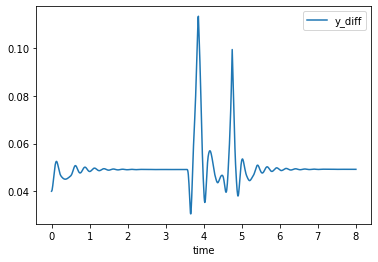

In [30]:
results.plot(x='time', y='y_diff')

<AxesSubplot:xlabel='time'>

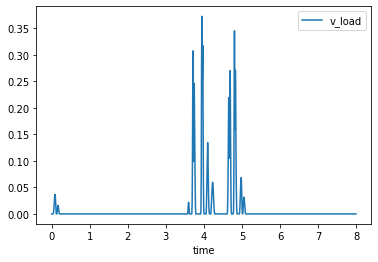

In [31]:
results.plot(x='time', y='v_load')

In [32]:
ffs.evaluate.Sample?

Init signature: ffs.evaluate.Sample(acc_path: str, adc_path: str, video_labels_path: str) -> None
Docstring:      A class for holding groundtruth sample data
File:           ~/Nextcloud/nextcloud/PhD/Python/unified_model/ffs/utils/utils.py
Type:           type
Subclasses:     


In [33]:
sample = ffs.evaluate.Sample(
    acc_path='../data/2019-05-23/A/log_04_acc.csv',
    adc_path='../data/2019-05-23/A/log_04_adc.csv',
    video_labels_path='../data/2019-05-23/A/a004_transcoded_subsampled_labels_2019-10-31-10:24:04.csv'
)

In [34]:
solve_kwargs = dict(
    t_start=0,
    t_end=8,
    y0=[0., 0., 0.04, 0., 0.],  # initial conditions
    t_eval=np.linspace(0, 8, 1000),
    t_max_step=1e-3
)

In [35]:
results, _ = model.score_sample(
    sample=sample,
    solve_kwargs=solve_kwargs,
    y_diff_expr='x3-x1',
    mech_metrics_dict={'y_diff_dtw_distance_norm': ffs.metrics.dtw_euclid_norm_by_length},
    v_load_expr='g(t, x5)',
    elec_metrics_dict={'rms_perc_diff': ffs.metrics.root_mean_square_percentage_diff}
                       
)

In [36]:
evaluators = _

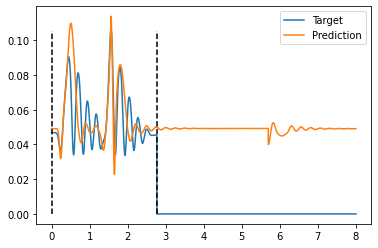

In [37]:
mech_evaluator = evaluators['mech']
mech_evaluator.poof()

In [38]:
results

{'y_diff_dtw_distance_norm': 0.004593695478977788,
 'rms_perc_diff': 0.029389835098693005}

In [39]:
model.get_config()

{'height': 0.12,
 'magnet_assembly': {'m': 1,
  'l_m_mm': 10,
  'l_mcd_mm': 0,
  'dia_magnet_mm': 10,
  'dia_spacer_mm': 0},
 'magnetic_spring': {'fea_data_file': '/Users/michael/Nextcloud/nextcloud/PhD/Python/unified_model/data/magnetic-spring/10x10alt.csv',
  'filter_callable': 'auto',
  'magnet_assembly': 'dep:magnet_assembly'},
 'mechanical_spring': {'magnet_assembly': 'dep:magnet_assembly',
  'strength': 10000000.0,
  'damping_coefficient': 3.108},
 'mechanical_damper': {'damping_coefficient': 4.272,
  'magnet_assembly': 'dep:magnet_assembly'},
 'input_excitation': {'raw_accelerometer_data_path': '/Users/michael/Nextcloud/nextcloud/PhD/Python/unified_model/data/2019-05-23/A/log_04_acc.csv',
  'accel_column': 'z_G',
  'time_column': 'time(ms)',
  'accel_unit': 'g',
  'time_unit': 'ms',
  'smooth': True,
  'interpolate': True},
 'coil_configuration': {'c': 1,
  'n_z': 15,
  'n_w': 17,
  'l_ccd_mm': 0,
  'ohm_per_mm': 0.0010789999999999999,
  'tube_wall_thickness_mm': 2,
  'coil_wire